In [1]:
import os
import warnings
import pprint

import xarray as xr
import numpy as np
import toml
import torch
from scipy.ndimage import gaussian_filter, gaussian_filter1d

import libVoodoo.TorchModel as TM
import libVoodoo.Loader as Loader

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LogNorm
%matplotlib inline

warnings.filterwarnings("ignore")

p = 0.4
model_setup_file = f'VnetSettings-1.toml'
torch_settings = toml.load(os.path.join(model_setup_file))['pytorch']

In [2]:
import datetime
def dt_to_ts(dt):
    """datetime to unix timestamp"""
    # return dt.replace(tzinfo=datetime.timezone.utc).timestamp()
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

def ts_to_dt(ts):
    """unix timestamp to dt"""
    return datetime.datetime.utcfromtimestamp(ts)

def decimalhour2unix(dt, time):
    return np.array([x*3600. + dt_to_ts(datetime.datetime(int(dt[:4]), int(dt[4:6]), int(dt[6:]), 0, 0, 0)) for x in time]).astype(int).astype( 'datetime64[s]')

def lin2z(array):
    """linear values to dB (for np.array or single number)"""
    return 10 * np.ma.log10(array)

def open_xarray_datasets(path):
    import re
    ds = xr.open_mfdataset(path, parallel=True, decode_times=False, )
    x = re.findall("\d{8}", path)[0]
    # convert time to unix
    ds = ds.assign_coords(time = decimalhour2unix(str(x), ds['time'].values))
    ds['time'].attrs['units'] = 'UTC'


    return ds

In [3]:
def VoodooPredictor(X):
    """
    Predict probability disribution over discrete set of 3 classes (dummy, CD, non-CD) .
    
    Args:
        X: list of [256, 6, 1] time spectrograms, dimensitons: (N_Doppler_bins, N_time_steps, N_range_gate)
        
        
    Return:
        predicitons: list of predictions 
    """
    torch_settings.update({'dev': 'cpu'})
    #trained_model = 'Vnet0x60de1687-fnX-gpu0-VN.pt' 
    trained_model = 'Vnet0x615580bf-fn1-gpu0-VN.pt'

    print(f'Loading Vnet model ...... {model_setup_file}')

    # (n_samples, n_Doppler_bins, n_time_steps)
    X = X[:, :, :, np.newaxis]
    X = X.transpose(0, 3, 2, 1)
    X_test = torch.Tensor(X)

    model = TM.VoodooNet(X_test.shape, 3, **torch_settings)
    model.load_state_dict(torch.load(trained_model, map_location=model.device)['state_dict'])

    prediction = model.predict(X_test, batch_size=256)
    prediction = prediction.to('cpu')
    return prediction

# RPG-FMCW94 test

In [4]:
from rpgpy import read_rpg
from rpgpy.spcutil import spectra2moments

data_path = 'example_data/RPG-FMCW94/'
file_name = '190801_060001_P05_ZEN.LV0'
#file_name = '181210_040003_P03_ZEN.LV0'
cat_file_name = f'20{file_name[:6]}-punta-arenas-categorize-limrad94.nc'
rpg_lv0_header, rpg_lv0_data = read_rpg(data_path+file_name)

In [5]:
# replace fill values
nonzeros_spectra = rpg_lv0_data['TotSpec'] > 0.0
rpg_spectra_vh = Loader.replace_fill_value(rpg_lv0_data['TotSpec'], rpg_lv0_data['SLv'])
rpg_spectra_h = Loader.replace_fill_value(rpg_lv0_data['HSpec'], rpg_lv0_data['SLh'])

In [6]:
# time since 2001-01-01 to UNIX to numpy.datetime64
ts_list = rpg_lv0_data['Time'] + dt_to_ts(datetime.datetime(2001, 1, 1))
dt_list = [ts_to_dt(ts) for ts in ts_list]
np_dt_list = np.array([np.datetime64(ts,'s') for ts in dt_list])
t0_radar, t1_radar = np_dt_list[0], np_dt_list[-1]

In [7]:
# input categorize data
# slice clounet categorize file 
cn_data = open_xarray_datasets(data_path+cat_file_name)
cn_data = cn_data.sel(time=slice(t0_radar, t1_radar))

ts_main = [get_unixtime(ts.values) for ts in cn_data['time']]
    
# preprocess spectra, create time-spectrograms
interp_var, interp_mask = Loader.hyperspectralimage(
    ts_list, # radar time resolution
    rpg_spectra_vh, # vertica+horizontal spectra
    rpg_spectra_h, # horizontal spectra
    nonzeros_spectra, # nonzero mask of spectra
    6, # number of time steps used for time spectrogram
    ts_main # target time resolution
)

nonzeros_mask = (interp_mask.any(axis=3)).any(axis=2)

In [8]:
# create feature list
spectra_list = []
for ind_t in range(nonzeros_mask.shape[0]):
    for ind_h in range(nonzeros_mask.shape[1]):
        if nonzeros_mask[ind_t, ind_h]:
            spectra_list.append(interp_var[ind_t, ind_h, :, :, 0])
            
spectra_list = np.array(spectra_list)
spectra_list = lin2z(spectra_list) 

In [9]:
# normalize features between 0 and 1
Z_min, Z_max = -50, 20
X = (spectra_list - Z_min) / (Z_max - Z_min)

In [10]:
# inference mode
prediction = VoodooPredictor(X)

Loading Vnet model ...... VnetSettings-1.toml


0.0

In [18]:
# smooth predictions
prediction_smoothed = np.zeros((nonzeros_mask.shape)+(prediction.shape[1],))
for i in range(prediction.shape[1]):
    _tmp = TM.VoodooNet.reshape(prediction[:, i], ~nonzeros_mask)
    _tmp = gaussian_filter(_tmp, sigma=1)
    prediction_smoothed[:, :, i] = np.ma.masked_where(~nonzeros_mask, _tmp)
    


In [37]:
# plot example spectrum
ind = X[:, :, 1].argmax()
plt.pcolormesh(X[ind].T)
print(f'probability for CD = {X[ind]:.3f}')

IndexError: index 338261 is out of bounds for axis 0 with size 9536

In [13]:
# add new data array to data set
cn_data['voodoo'] = cn_data['v'].copy()
cn_data['voodoo'].attrs.update({
    'units': '1', 
    'long_name': 'probability for cloud droplets', 
    'comment': 'Voodoo retrieval output'
})
cn_data['voodoo'].values = prediction_smoothed[:, :, 1]

In [14]:
# Voodoo cloud droplet likelyhood colorbar (viridis + grey below minimum value)
from matplotlib import cm
viridis = cm.get_cmap('viridis', 8)
newcolors = viridis(np.linspace(0, 1, 256))
newcolors[:1, :] = np.array([220/256, 220/256, 220/256, 1])
p_cmap = ListedColormap(newcolors)



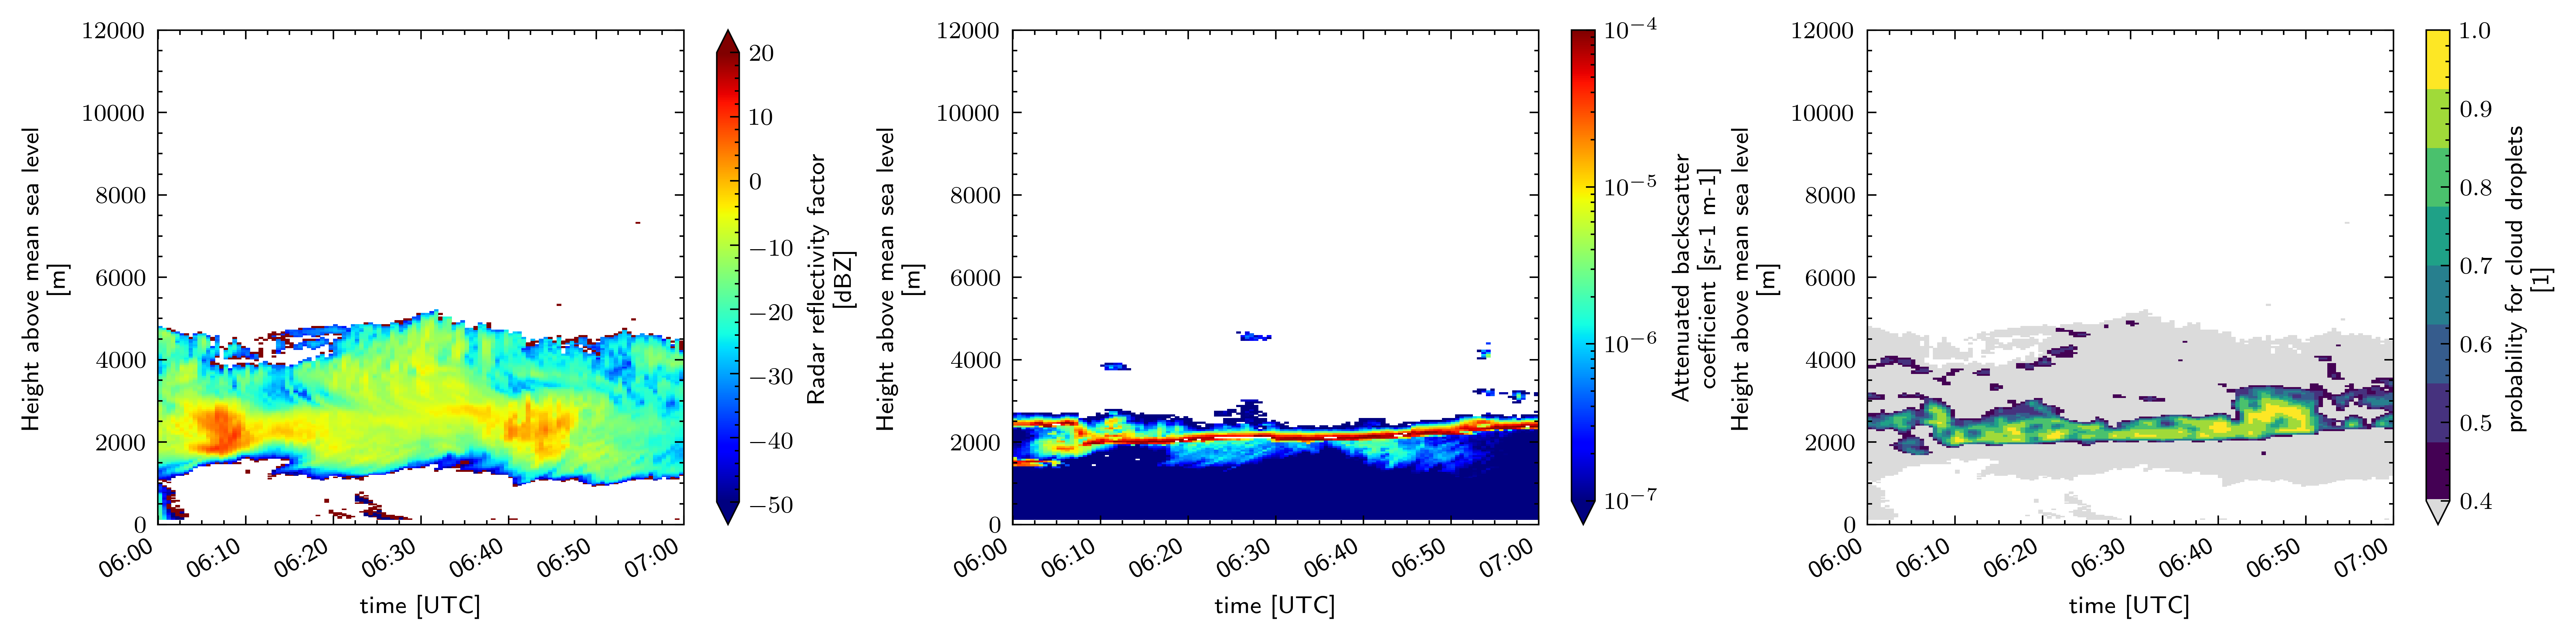

In [15]:
# quicklook Ze, beta, P(CD)
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots(ncols=3, figsize=(14,3))

    cn_data['Z'].values = np.ma.masked_where(~nonzeros_mask, cn_data['Z'])
    cn_data['Z'].T.plot(vmin=Z_min, vmax=Z_max, cmap='jet', ax=ax[0])
    
    cn_data['beta'].values = np.ma.masked_where(cn_data['beta']>1.0e-4, cn_data['beta'])
    cn_data['beta'].T.plot(norm = LogNorm(vmin=1.0e-7, vmax=1.0e-4), cmap='jet', ax=ax[1])
    
    cn_data['voodoo'].values = np.ma.masked_where(~nonzeros_mask, prediction_smoothed[:, :, 1])
    cn_data['voodoo'].T.plot(vmin=p, vmax=1, cmap=p_cmap, ax=ax[2])
    
    for iax in ax:
        iax.set_ylim((0,12000))
        iax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    fig.subplots_adjust(wspace=0.3)